# Self-Attention

This notebook is a hands-on code walkthrough of how self-attention is defined. Specifically, looking at the scaled Dot-Product Attention image below, we will be replicating those steps with to understand how Transformers "add context" to a given sentence

In [2]:
import math
import numpy as np
from IPython.display import Image, display

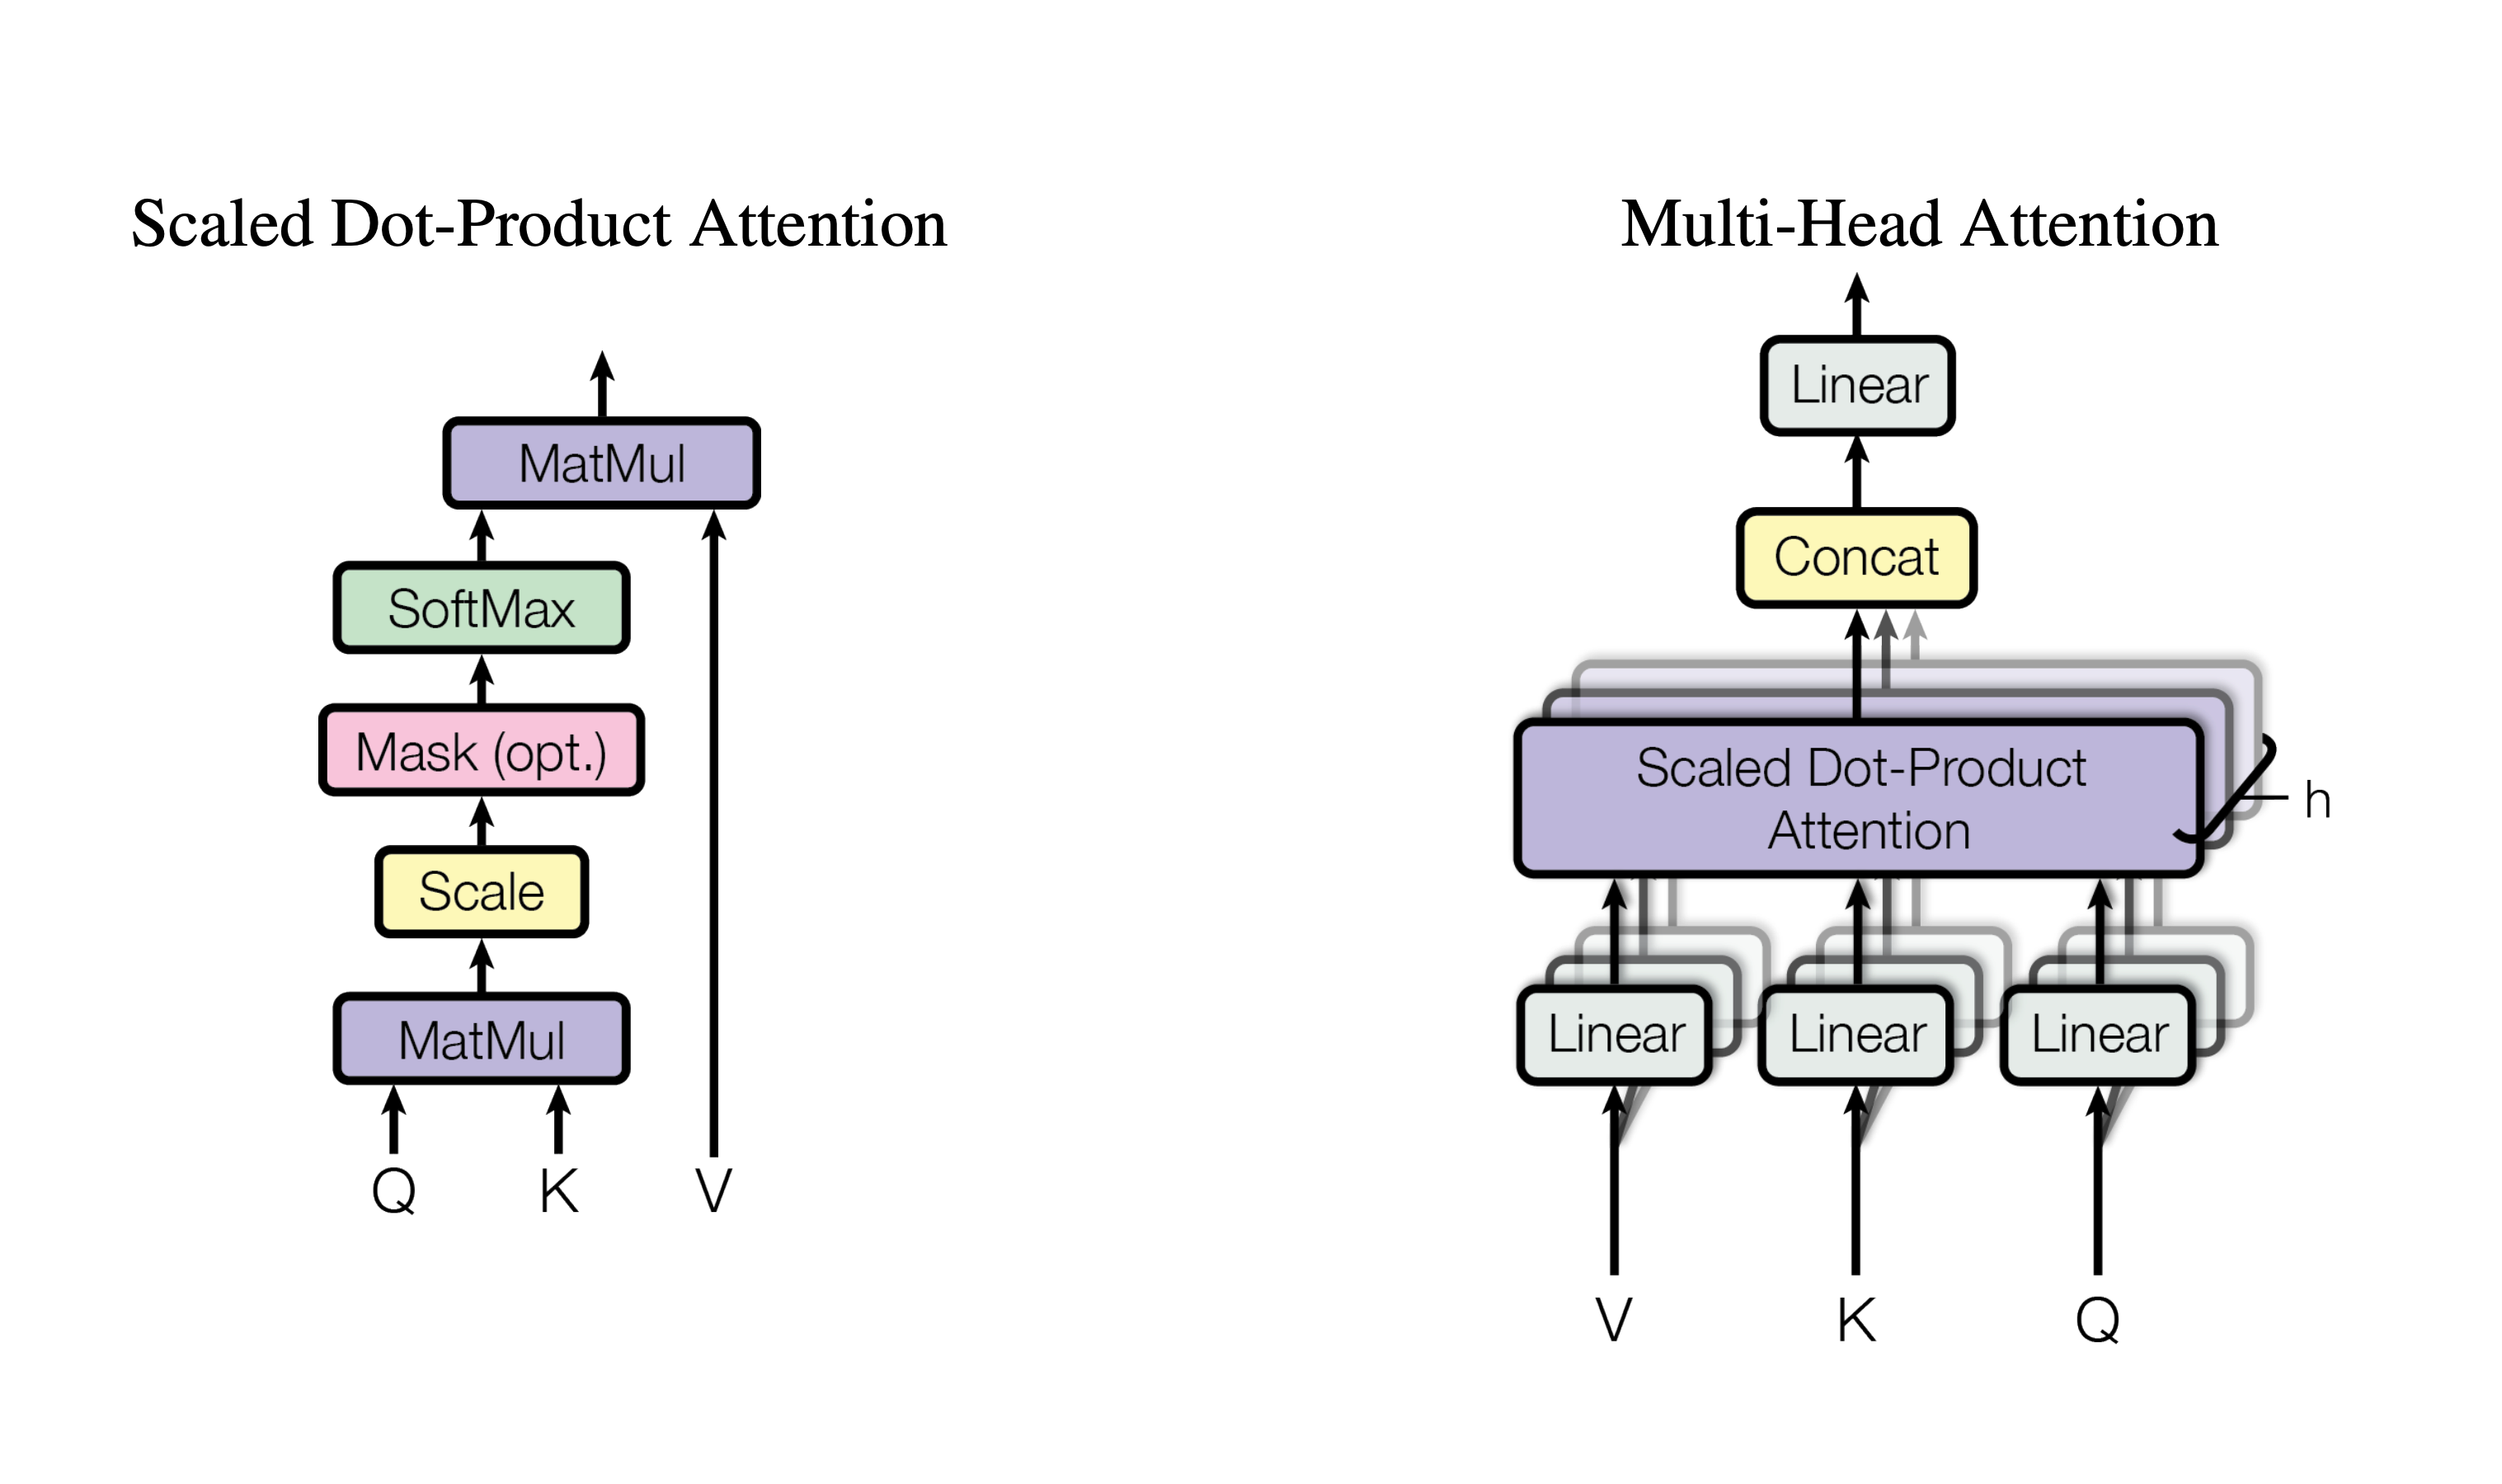

In [3]:
display(Image(filename='images/attention.png'))

### Query (Q)
- What am I looking for?
- Sequence length x $d_k$

### Key (K)
- What I can offer?
- sequence length x $d_k$

### Value (V)
- What I actually offer
- sequence length x $d_v$

# Code

If I had a sample sentence of 4 words, such as:
- "My name is Ashish"

And I want to calculate the self-attention matrix for it, I would first need to create the Q, K, V matrix(s), with the same length. 

In [7]:
# Correponds to length of input squence of input sentence "My name is Ashish"
length_of_input_sequence = 4

# Arbitrary for illustrating function.
d_k = 8
d_v = 8

In [9]:
q = np.random.randn(length_of_input_sequence, d_k)
k = np.random.randn(length_of_input_sequence, d_k)
v = np.random.randn(length_of_input_sequence, d_v)

In [11]:
print("Q\n", q, "\n")
print("K\n", k, "\n")
print("V\n", v, "\n")

Q
 [[-0.45864574 -0.43512833  0.33638565 -1.87993655 -1.08014445  2.03603931
  -1.54510753 -1.67478347]
 [-0.72144924  0.52118181 -0.0480261   2.42484841 -0.99855404 -1.55709908
  -0.70793382 -0.3115167 ]
 [ 0.45631625 -0.42448395  0.81594285  0.34866696  0.10734628 -0.79575747
  -0.22426591 -1.31418257]
 [-0.49844182 -1.44350324 -0.50887836  0.10191212 -1.43098891 -0.20243513
  -1.088907   -1.0078006 ]] 

K
 [[-0.75671995 -1.54593539 -0.60863047  0.15097021  0.18287751 -0.84459691
  -0.33543034 -0.08318158]
 [ 2.41408773 -0.10555685  0.07116987  0.91749989 -1.14504371  0.78270297
   0.07685541  0.47691467]
 [ 0.38385344 -1.41018208  1.00381134  1.12853646  1.22857917 -0.34209592
  -0.56949223 -0.2006834 ]
 [-0.19602807 -1.00155043  0.16237048 -1.19877024  0.50294955  1.20569207
  -2.02238022 -0.73366186]] 

V
 [[ 1.40679505  0.14740795 -1.61585349 -0.35486807  1.34981549  0.48435575
   0.23982082 -2.64451182]
 [-0.0205047  -1.70054296  0.35436464  1.19589432 -1.04353735  2.64467508
  

# Self-Attention Formula

$$ Self Attention = softmax \biggl( \frac{Q*K^T}{\sqrt(d_k)} + M \biggr) V$$

In [12]:
np.matmul(q, k.T)

array([[-0.72838187, -0.84923338, -2.15388755,  9.09903944],
       [ 1.53141456,  0.14639061,  1.44798224, -4.01454475],
       [ 0.74321868,  0.13462017,  2.78185539,  0.5624726 ],
       [ 3.29221146, -0.07784807,  0.58200944,  3.31643304]])

In [13]:
# Why we need sqrt(d_k) in denominator
q.var(), k.var(), np.matmul(q, k.T).var()

(0.9463242533720309, 0.8791048559888184, 7.777591864707583)

As from above, you can see that the variance of q and k, are around 1. However, for the variance for the dot-product of q and k, is really high. We divide by square-root of d_k, as a scaling factor

In [14]:
scaled = np.matmul(q, k.T) / math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(0.9463242533720309, 0.8791048559888184, 0.9721989830884477)

### Masking
- This is done to ensure words don't get context from words generated in the future.
- Not required in the encoders, but required only in the decoders

In [19]:
mask = np.tril(np.ones((length_of_input_sequence, length_of_input_sequence)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

Transforming the above mask to be 0 & negative infinity instead of 0s and 1s, as we perform a softmax opperation on the masked values

In [20]:
mask[mask == 0] = -np.infty
mask[mask == 1] = 0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [21]:
scaled + mask

array([[-0.25752188,        -inf,        -inf,        -inf],
       [ 0.54143681,  0.05175689,        -inf,        -inf],
       [ 0.26276749,  0.04759542,  0.9835344 ,        -inf],
       [ 1.16397252, -0.02752345,  0.20577141,  1.17253615]])

# Softmax

$$ softmax = \frac{e^{x_i}}{\sum_j{e^x_j}}$$

In [22]:
def softmax(x):
    return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

In [25]:
attention = softmax(scaled)
attention

array([[0.02869889, 0.02749849, 0.0173374 , 0.92646523],
       [0.36703951, 0.22493007, 0.35637078, 0.05165964],
       [0.2083113 , 0.16798279, 0.42828999, 0.19541592],
       [0.37092687, 0.11267516, 0.14228098, 0.37411699]])

In [26]:
attention_with_mask = softmax(scaled + mask)
attention_with_mask

array([[1.        , 0.        , 0.        , 0.        ],
       [0.62003103, 0.37996897, 0.        , 0.        ],
       [0.25890557, 0.20878214, 0.53231229, 0.        ],
       [0.37092687, 0.11267516, 0.14228098, 0.37411699]])

In [27]:
new_v = np.matmul(attention_with_mask, v)
new_v

array([[ 1.40679505,  0.14740795, -1.61585349, -0.35486807,  1.34981549,
         0.48435575,  0.23982082, -2.64451182],
       [ 0.86446543, -0.55475606, -0.86723173,  0.23437353,  0.44041567,
         1.30521007,  0.40311583, -0.81809817],
       [ 0.57612713,  0.20365702, -1.13174762,  0.66512479, -0.11107621,
         0.59599889,  0.72279486,  0.31771211],
       [ 0.58579093, -0.17768681, -0.45276238, -0.13560836, -0.49763627,
         0.47186788,  0.21807273, -0.67902774]])

In [28]:
v

array([[ 1.40679505,  0.14740795, -1.61585349, -0.35486807,  1.34981549,
         0.48435575,  0.23982082, -2.64451182],
       [-0.0205047 , -1.70054296,  0.35436464,  1.19589432, -1.04353735,
         2.64467508,  0.66957963,  2.16223237],
       [ 0.406117  ,  0.97787577, -1.47916774,  0.95305096, -0.45589591,
        -0.15322668,  0.97857528,  1.03502296],
       [ 0.02272146, -0.48083503,  0.84767721, -0.73326491, -2.1807966 ,
         0.04281916, -0.2287009 , -0.23789667]])

# Combining everything above to create reusable functions

In [29]:
def softmax(x):
    return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.shape[-1]
    scaled = np.matmul(q, k.T) / math.sqrt(d_k)

    if mask is not None:
        scaled = scaled + mask

    attention = softmax(scaled)
    out = np.matmul(attention, v)
    return out, attention

In [31]:
# Example without mask (As will be used in encoder)
out, attention = scaled_dot_product_attention(q, k, v, mask=None)
print("Q\n", q, "\n")
print("K\n", k, "\n")
print("V\n", v, "\n")
print("New out\n", out, "\n")
print("New attention\n", attention, "\n")

Q
 [[-0.45864574 -0.43512833  0.33638565 -1.87993655 -1.08014445  2.03603931
  -1.54510753 -1.67478347]
 [-0.72144924  0.52118181 -0.0480261   2.42484841 -0.99855404 -1.55709908
  -0.70793382 -0.3115167 ]
 [ 0.45631625 -0.42448395  0.81594285  0.34866696  0.10734628 -0.79575747
  -0.22426591 -1.31418257]
 [-0.49844182 -1.44350324 -0.50887836  0.10191212 -1.43098891 -0.20243513
  -1.088907   -1.0078006 ]] 

K
 [[-0.75671995 -1.54593539 -0.60863047  0.15097021  0.18287751 -0.84459691
  -0.33543034 -0.08318158]
 [ 2.41408773 -0.10555685  0.07116987  0.91749989 -1.14504371  0.78270297
   0.07685541  0.47691467]
 [ 0.38385344 -1.41018208  1.00381134  1.12853646  1.22857917 -0.34209592
  -0.56949223 -0.2006834 ]
 [-0.19602807 -1.00155043  0.16237048 -1.19877024  0.50294955  1.20569207
  -2.02238022 -0.73366186]] 

V
 [[ 1.40679505  0.14740795 -1.61585349 -0.35486807  1.34981549  0.48435575
   0.23982082 -2.64451182]
 [-0.0205047  -1.70054296  0.35436464  1.19589432 -1.04353735  2.64467508
  

In [32]:
# Example with mask (As will be used in decoder)
out, attention = scaled_dot_product_attention(q, k, v, mask=mask)
print("Q\n", q, "\n")
print("K\n", k, "\n")
print("V\n", v, "\n")
print("New out\n", out, "\n")
print("New attention\n", attention, "\n")

Q
 [[-0.45864574 -0.43512833  0.33638565 -1.87993655 -1.08014445  2.03603931
  -1.54510753 -1.67478347]
 [-0.72144924  0.52118181 -0.0480261   2.42484841 -0.99855404 -1.55709908
  -0.70793382 -0.3115167 ]
 [ 0.45631625 -0.42448395  0.81594285  0.34866696  0.10734628 -0.79575747
  -0.22426591 -1.31418257]
 [-0.49844182 -1.44350324 -0.50887836  0.10191212 -1.43098891 -0.20243513
  -1.088907   -1.0078006 ]] 

K
 [[-0.75671995 -1.54593539 -0.60863047  0.15097021  0.18287751 -0.84459691
  -0.33543034 -0.08318158]
 [ 2.41408773 -0.10555685  0.07116987  0.91749989 -1.14504371  0.78270297
   0.07685541  0.47691467]
 [ 0.38385344 -1.41018208  1.00381134  1.12853646  1.22857917 -0.34209592
  -0.56949223 -0.2006834 ]
 [-0.19602807 -1.00155043  0.16237048 -1.19877024  0.50294955  1.20569207
  -2.02238022 -0.73366186]] 

V
 [[ 1.40679505  0.14740795 -1.61585349 -0.35486807  1.34981549  0.48435575
   0.23982082 -2.64451182]
 [-0.0205047  -1.70054296  0.35436464  1.19589432 -1.04353735  2.64467508
  